In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"badaraguindo0012","key":"6332065097de4d751a97b333ac90f5f8"}'}

In [4]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d mlg-ulb/creditcardfraud


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.53GB/s]


In [6]:
!unzip creditcardfraud.zip


Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [7]:
df = pd.read_csv("creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


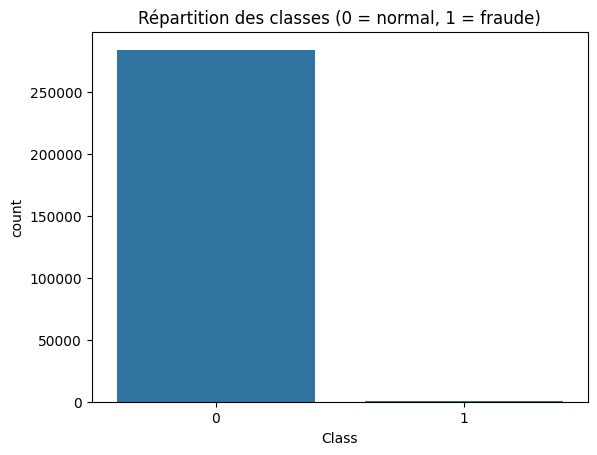

Class
0    284315
1       492
Name: count, dtype: int64
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Class')
plt.title("Répartition des classes (0 = normal, 1 = fraude)")
plt.show()

print(df['Class'].value_counts())
print(df['Class'].value_counts(normalize=True))


# Split et Normalisation

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop("Class", axis=1)
y = df["Class"]

# Standardisation des variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split stratifié pour garder le même pourcentage de fraudes dans le test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Taille train :", X_train.shape)
print("Taille test :", X_test.shape)
print("Fraudes dans train :", y_train.sum())
print("Fraudes dans test :", y_test.sum())


Taille train : (227845, 30)
Taille test : (56962, 30)
Fraudes dans train : 394
Fraudes dans test : 98


# Gestion de déséquilibre (SMOTE)

In [10]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Avant SMOTE :")
print(y_train.value_counts())

print("Après SMOTE :")
print(y_train_res.value_counts())


Avant SMOTE :
Class
0    227451
1       394
Name: count, dtype: int64
Après SMOTE :
Class
0    227451
1    227451
Name: count, dtype: int64


# Entrainement

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000, n_jobs=-1)

model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


# Evaluation

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



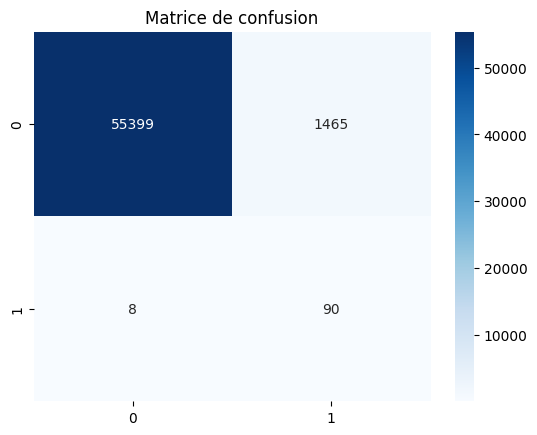

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.show()


In [15]:
from sklearn.metrics import roc_auc_score
print("ROC-AUC :", roc_auc_score(y_test, y_proba))


ROC-AUC : 0.970987885165321


# Amelioration du modele

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]


In [17]:
print(classification_report(y_test, y_pred_rf))

from sklearn.metrics import roc_auc_score
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9514480665648364


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ))
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [19]:
from sklearn.metrics import classification_report

y_pred_pipe = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_pipe))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [20]:
import joblib

joblib.dump(pipeline, "fraud_detection_model.pkl")
print("Modèle sauvegardé !")


Modèle sauvegardé !


In [22]:
from google.colab import files

files.download("fraud_detection_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>